# T019 · Molecular dynamics simulation

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Pietro Gerletti, CADD seminar 2020, Charité/FU Berlin
- Mareike Leja, 2020/21, Internship at [Volkamer Lab, Charité](https://volkamerlab.org/)
- Jeffrey R Wagner, 2020, [Open Force Field Consortium](https://openforcefield.org/)
- David Schaller, 2020/21, [Volkamer Lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2020/21, [Volkamer Lab, Charité](https://volkamerlab.org/)

__Note__

This talktorial was designed to be used with [Google Colab](https://colab.research.google.com/github/volkamerlab/teachopencadd/blob/1bd7cb0c9f6379aebc0c1a0b1c7413685910cffa/teachopencadd/talktorials/019_md_simulation/talktorial.ipynb). It is also possible to use it on a local computer. However, performing the molecular dynamics simulation may take a considerably long time if no GPU is available.

Also, note that this talktorial **will not run on Windows** for the time being (check progress in [this issue](https://github.com/volkamerlab/teachopencadd/issues/136)).

## Aim of this talktorial

In this talktorial, we will learn why molecular dynamics (MD) simulations are important for drug design and which steps are necessary to perform an MD simulation of a protein in complex with a ligand. The kinase EGFR will serve as sample system for simulation.

### Contents in *Theory*

- Molecular dynamics
- Force fields
- Boundary conditions
- MD simulations and drug design
- EGFR kinase

### Contents in *Practical*

- Installation on Google Colab
- Adjust environment for local installations running on Linux or MacOS
- Import dependencies
- Download PDB file
- Prepare the protein ligand complex
  - Protein preparation
  - Ligand preparation
  - Merge protein and ligand
- MD simulation set up
  - Force field
  - System
- Perform the MD simulation
- Download results

### References

- Review on the impact of MD simulations in drug discovery ([_J Med Chem_ (2016), **59**(9), 4035‐4061](https://doi.org/10.1021/acs.jmedchem.5b01684))
- Review on the physics behind MD simulations and best practices ([_Living J Comp Mol Sci_ (2019), **1**(1), 5957](https://doi.org/10.33011/livecoms.1.1.5957))
- Review on force fields ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042))
- Review on EGFR in cancer ([_Cancers (Basel)_ (2017), **9**(5), 52](https://dx.doi.org/10.3390%2Fcancers9050052))
- Summarized statistical knowledge from Pierre-Simon Laplace ([Théorie Analytique des Probabilités _Gauthier-Villars_ (1820), **3**)](https://archive.org/details/uvrescompltesde31fragoog/page/n15/mode/2up)
- Inspired by a notebook form Jaime Rodríguez-Guerra ([github](https://github.com/jaimergp/uab-msc-bioinf/blob/master/MD%20Simulation%20and%20Analysis%20in%20a%20Notebook.ipynb))
- Repositories of [OpenMM](https://github.com/openmm/openmm) and [OpenMM Forcefields](https://github.com/openmm/openmmforcefields), [RDKit](https://github.com/rdkit/rdkit), [PyPDB](https://github.com/williamgilpin/pypdb), [MDTraj](https://github.com/mdtraj/mdtraj), [PDBFixer](https://github.com/openmm/pdbfixer)
- Wikipedia articles about [MD simulations](https://en.wikipedia.org/wiki/Molecular_dynamics), [AMBER](https://en.wikipedia.org/wiki/AMBER) and [force fields](https://en.wikipedia.org/wiki/Force_field_(chemistry)) in general

## Theory

### Molecular dynamics

Molecular dynamics is a computational method analyzing the movements and interactions of atoms and molecules of a defined system. The method stems from theoretical physics, where it was developed in the 1950s (Alder and Wainwright in [_J Chem Phys_ (1959), **31**(2), 459](https://doi.org/10.1063/1.1730376)), although the ideas behind it can be dated much earlier:

> An intelligence which could, at  any moment, comprehend all the forces by  which nature is animated and the  respective positions of the  beings of which it is  composed, and moreover, if this intelligence were far-reaching enough to subject these data to  analysis, it would encompass in that formula both the movements of the  largest bodies in  the universe and those of the lightest atom: to it nothing would be uncertain, and the  future, as well as the past, would be present to its eyes. The human mind offers us, in the perfection which it has  given to  astronomy, a faint sketch of this intelligence. (Pierre-Simon Laplace, 1820)


Let us just take this statement by Laplace as the ideological substrate underneath molecular dynamics simulations. In other terms, we can approximate the behavior of a physical system by knowing the characteristics of its components and applying Newton's laws of motion. By solving the equations of motion, we can obtain a molecular trajectory of the system, which is a series of snapshots with the positions and velocities of all its particles, as well as its potential energy. To do so, we define functions, called force fields, which provide an approximate description of all the forces applied to each particle in the system. We then use numerical integrators to solve the initial value problem for the system and obtain the trajectory. As it sounds, the process requires quite a bit of processing power and it was only few years ago that MD started seeing a more widespread use, especially in the field of computational chemistry and biology, as well as in drug discovery ([_J Med Chem_ (2016), **59**(9), 4035‐4061](https://doi.org/10.1021/acs.jmedchem.5b01684)).

![MD_rotor_250K_1ns.gif](https://github.com/volkamerlab/teachopencadd/raw/d1ded86bb2c82ef088cc5145d0bcb997f6eab7dd/teachopencadd/talktorials/018_md_simulation/images/MD_rotor_250K_1ns.gif)

**Figure 1**: Molecular dynamics simulation of the rotation of a supramolecule composed of three molecules in a confined nanoscopic pore (Palma et al. via [Wikimedia](https://commons.wikimedia.org/w/index.php?curid=34866205)).

### Force fields



Force fields describe the forces between atoms within and between molecules. They are parametric equations with components for different forces (bond stretching, van-der-Waals and more). The parameter values are usually derived experimentally and change for each MD scenario, depending on the molecules involved and the simulation settings. The result is a mathematical description of the energy landscape of the system, in which the forces acting on each particle result from the gradient of the potential energy with respect to the coordinates of the atoms.

Several force fields are available, each with its own characteristics ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042)). In this notebook, we will use a member of the AMBER force field family, which are widely used for MD simulations of proteins. Their functional form is:

$$V(r^N) = \sum_{i \in  bonds}k_{bi} (l_i-l^0_i)^2 + \sum_{i \in  angles}k_{ai}(\theta_i - \theta^0_i)^2 + \sum_{i\in torsions} \sum_n \frac{1}{2} V_i^n[1+cos(nw_i-\gamma_i)]$$
$$+ \sum_{j=1}^{N-1}\sum_{I=j+1}^{N} f_{ij}\in ij [(\frac{r^0_{ij}}{r_{ij}})^{12}-2(\frac{r^0_{ij}}{r_{ij}})^{6}]+\frac{q_iq_j}{4\pi \in_0 r_{ij}}$$

The formula consists of a sum of different components. The first three components contain information about bond lengths, angles and torsions (intramolecular forces). The last component describes intermolecular, non-bonded forces like van-der-Waals forces and electrostatic interactions. The various parameters, denoted by a superscript 0, depend on the force field used and vary between all members of the AMBER force field family. Note that these force fields assume fixed-charge particles and do not allow polarization, nor do they consider how a local charge influences its surroundings. 

The following visual representation of force fields components shows the same concepts in a more intuitive way.

![MM_PEF.png](https://github.com/volkamerlab/teachopencadd/raw/d1ded86bb2c82ef088cc5145d0bcb997f6eab7dd/teachopencadd/talktorials/018_md_simulation/images/MM_PEF.png)

**Figure 2**: Components of a molecular mechanics force field (Edboas via [Wikimedia](https://commons.wikimedia.org/w/index.php?curid=4194424)).

### Boundary conditions

Often, molecular systems are simulated in a box filled with solvent such as water. These boxes are of finite size, which results in problems for molecules at or near the box boundaries. With which molecules should those interact? Periodic boundary conditions can avoid such boundary artifacts by simulating a theoretically infinite system. Molecules at one boundary of the box thereby interact with molecules at the boundary on the other side of the box. This mimics a situation, in which the simulation box is surrounded by replicas of itself. When visualizing such MD simulations, one can often observe that particles leave the box at one side (Fig. 3). However, they re-appear at the same time on the other side of the box with the same velocity. For simulations under periodic boundary conditions, it is recommended to use a simulation box large enough, so that the simulated macromolecule does not come into contact with neighboring images of itself.

![MD_water.gif](https://github.com/volkamerlab/teachopencadd/raw/d1ded86bb2c82ef088cc5145d0bcb997f6eab7dd/teachopencadd/talktorials/018_md_simulation/images/MD_water.gif)

**Figure 3**: Molecular dynamics simulation of water molecules with periodic boundary conditions (Kmckiern via [Wikimedia](https://commons.wikimedia.org/wiki/File:MD_water.gif)).

### MD simulations and drug design

MD simulations give valuable insights into the highly dynamic process of ligand binding to their target. When a ligand (or a drug) approaches a macromolecule (protein) in solution, it encounters a structure in constant motion. Also, ligands may induce conformational changes in the macromolecule that can best accommodate the small molecule. Such conformations may not be discovered with static methods. Accordingly, binding sites that are not observed in static ligand-free structures, but can be discovered with MD simulations, are sometimes called *cryptic binding sites* ([_J Med Chem_ (2016), **59**(9), 4035‐4061](https://doi.org/10.1021/acs.jmedchem.5b01684)). The identification of such binding sites with MD simulation can kickstart new drug discovery campaigns. Later in the drug discovery process, MD simulations can also be used to estimate the quality of computationally identified small molecules before performing more costly and time-intensive *in vitro* tests. Altogether, MD simulations pose a valuable asset in computational drug design.

### EGFR kinase

The **E**pidermal **G**rowth **F**actor **R**eceptor (EGFR) is an important drug target with implications in cancer and inflammation ([Wikipedia](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)). It is a transmembrane protein with an extracellular receptor domain and an intracellular kinase domain. The binding of the endogenous ligand epidermal growth factor results in activation of the kinase domain via dimerization and autophosphorylation. The activated kinase domain can then phosphorylate downstream signaling proteins triggering DNA synthesis and cell proliferation ([_Cancers (Basel)_ (2017), **9**(5), 52](https://dx.doi.org/10.3390%2Fcancers9050052)). Inhibition of this kinase is the underlying mechanism of action of several already approved cancer drugs ([DrugBank](https://go.drugbank.com/bio_entities/BE0000767)). In this talktorial, we use the PDB structure **3POZ** of this kinase, which is in complex with the small molecule inhibitor **03P**, to perform an MD simulation ([PDB: 3POZ](https://www.rcsb.org/structure/3poz)).

![3poz_assembly-1.jpeg](https://github.com/volkamerlab/teachopencadd/raw/ed3b2b6b655589d71355295af4c89363a63558b9/teachopencadd/talktorials/018_md_simulation/images/3poz_assembly-1.jpeg)

**Figure 4**: Structure 3POZ of the EGFR kinase domain bound to inhibitor 03P ([PDB: 3POZ](https://www.rcsb.org/structure/3poz)).

## Practical

We will now proceed to perform an MD simulation using the molecular dynamics engine [OpenMM](https://github.com/openmm/openmm), a high performance toolkit for molecular simulation. It is open source and can be used as application or library. We will use it as Python library.

### Installation on Google Colab

The following code cells will install all required packages, if you are working on [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb). Installing the [condacolab](https://github.com/jaimergp/condacolab) package will restart the kernel, which is intended. This notebook can also be used on a local computer but requires considerable computing power.

In [1]:
try:
    import google.colab

    !pip install condacolab
    import condacolab

    condacolab.install()
except ModuleNotFoundError:
    pass

In [2]:
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output

    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj openmm openmmforcefields openff-toolkit pdbfixer pypdb rdkit
except ModuleNotFoundError:
    on_colab = False
else:
    # check if installation was succesful
    try:
        import rdkit

        on_colab = True
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

### Adjust environment for local installations running on Linux or MacOS

In [3]:
import sys

if not on_colab and sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c conda-forge openmmforcefields
    # Notes:
    # - If you do not have mamba installed, install it or use conda instead
    # - Under MacOS with an M1 chip you may need to use
    #   CONDA_SUBDIR=osx-64 in front of the above command

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


### Import dependencies

In [4]:
import copy
from pathlib import Path

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [5]:
# create data directory if not exists
HERE = Path(_dh[-1])
DATA = HERE / "data"
DATA.mkdir(exist_ok=True)

### Download PDB file
The Protein Data Bank ([PDB](https://www.rcsb.org/)) allows for easy downloading of files via url.

In [6]:
pdbid = "3POZ"
ligand_name = "03P"
pdb_path = DATA / f"{pdbid}.pdb"
pdb_url = f"https://files.rcsb.org/download/{pdbid}.pdb"

In [7]:
r = requests.get(pdb_url)
r.raise_for_status()
with open(pdb_path, "wb") as f:
    f.write(r.content)

### Prepare the protein ligand complex

#### Protein preparation

A crucial part for successful simulation is a correct and complete system. Crystallographic structures retrieved from the Protein Data Bank often miss atoms, mainly hydrogens, and may contain non-standard residues. In this talktorial, we will use the Python package [PDBFixer](https://github.com/openmm/pdbfixer) to prepare the protein structure. However, co-crystallized ligands are not handled well by [PDBFixer](https://github.com/openmm/pdbfixer) and will thus be prepared separately.

In [8]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    Use pdbfixer to prepare the protein from a PDB file. Hetero atoms such as ligands are
    removed and non-standard residues replaced. Missing atoms to existing residues are added.
    Missing residues are ignored by default, but can be included.

    Parameters
    ----------
    pdb_file: pathlib.Path or str
        PDB file containing the system to simulate.
    ignore_missing_residues: bool, optional
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool, optional
        If missing residues at the beginning and the end of a chain should be ignored or built.
    ph: float, optional
        pH value used to determine protonation state of residues

    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms

    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]

    # if all missing residues shall be ignored ignored, clear the dictionary
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [9]:
# prepare protein and build only missing non-terminal residues
prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)

#### Prepare ligand

After preparing the protein, we turn our attention to the ligand. Again, we need to add hydrogens, but also need to make sure the bond orders are correctly assigned, since some PDB entries may contain errors. We use the Python package [RDKit](https://github.com/rdkit/rdkit), an open source cheminformatics library.
We will provide the correct protonation state and bond orders to [RDKit](https://github.com/rdkit/rdkit) via a SMILES string. Uncharged isomeric SMILES strings for each co-crystallized ligand can be found in their respective [PDB](https://www.rcsb.org) entry. The ligand of PDB entry [3POZ](https://www.rcsb.org/structure/3poz) has the name [03P](https://www.rcsb.org/ligand/03P). If a ligand is likely to bind in its charged form or as a specific tautomer, such characteristics need to be incorporated into the SMILES string.

In [10]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    Prepare a ligand from a PDB file via adding hydrogens and assigning bond orders. A depiction
    of the ligand before and after preparation is rendered in 2D to allow an inspection of the
    results. Huge thanks to @j-wags for the suggestion.

    Parameters
    ----------
    pdb_file: pathlib.PosixPath
       PDB file containing the ligand of interest.
    resname: str
        Three character residue name of the ligand.
    smiles : str
        SMILES string of the ligand informing about correct protonation and bond orders.
    depict: bool, optional
        show a 2D representation of the ligand

    Returns
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand

Calling this function with the isomeric SMILES string taken from the PDB entry for [03P](https://www.rcsb.org/ligand/03P) returns a correctly prepared ligand. Printed is a 2D-representation of the original and the prepared ligand for inspection.

[11:21:29] WARNING: More than one matching pattern found - picking one



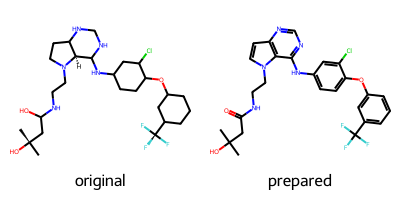

In [11]:
smiles = "CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)C(F)(F)F)c(Cl)c3)c12"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)

#### Merge protein and ligand

In the next step, we want to merge the prepared protein and ligand structures using the Python package [MDTraj](https://github.com/mdtraj/mdtraj). [MDTraj](https://github.com/mdtraj/mdtraj) can handle the prepared protein, which is currently a [PDBFixer](https://github.com/openmm/pdbfixer) molecule, a format that has a topology and atom positions similar to and usually interchangeable with [OpenMM Modeller](http://docs.openmm.org/latest/userguide/application.html#model-building-and-editing) topologies and positions. For the ligand however, we need to do several conversions, since it is currently an [RDKit](https://github.com/rdkit/rdkit) molecule.

In [12]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    Inspired by @hannahbrucemcdonald and @glass-w.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [13]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

Now protein and ligand are both in [OpenMM](https://github.com/openmm/openmm) like formats and can be merged with [MDTraj](https://github.com/mdtraj/mdtraj).

In [14]:
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: openmm.app.topology.Topology
        The merged topology.
    complex_positions: openmm.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [15]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)

/home/michael/miniconda3/envs/teachopencadd-t019/lib/python3.11/site-packages/openmm/unit/quantity.py:753: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [16]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 5561 atoms.


### MD simulation set up

We can now use the prepared complex to set up the MD simulation. 

#### Force field

Common force fields like AMBER have parameters for amino acids, nucleic acids, water and ions and usually offer several options to choose from depending on your aim. We use the `amber14-all.xml` force field file, which is shipped with OpenMM and includes parameters for proteins, DNA, RNA and lipids. For solvation we use the standard three-site [water model](https://en.wikipedia.org/wiki/Water_model) [**TIP3P**](https://aip.scitation.org/doi/10.1063/1.445869).

Parameters for ligands however are not included. To generate these parameters, we can use the **G**eneral **A**MBER **F**orce**F**ield ([GAFF](http://ambermd.org/antechamber/gaff.html)), which is implemented in the Python package [OpenMM Forcefields](https://github.com/openmm/openmmforcefields). The following function generates a force field object holding standard AMBER parameters and additionally includes parameters for a small molecule if required.

In [17]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [18]:
forcefield = generate_forcefield(rdkit_ligand)

#### System

With our configured force field we can now  use the  [OpenMM Modeller](http://docs.openmm.org/latest/userguide/application.html#model-building-and-editing) class to create the MD environment, a simulation box which contains the complex and is filled with a solvent. The standard solvent is water with a specified amount of ions. The size of the box can be determined in various ways. We define it with a padding, which results in a cubic box with dimensions dependent on the largest dimension of the complex.

> Note this step can take a long time, in the order of minutes, depending on your hardware.

In [19]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

With our solvated system and force field, we can finally create an [OpenMM System](http://docs.openmm.org/development/api-python/generated/openmm.openmm.System.html#openmm.openmm.System) and set up the simulation.
Additionally to the system the simulation needs an integrator. An [OpenMM Integrator](http://docs.openmm.org/development/api-python/library.html#integrators) defines a method for simulating a system by integrating the equations of motion. The chosen **Langevin Integrator** uses Langevin equations. A list of all different kinds of integrators can be found in the [OpenMM Docs](http://docs.openmm.org/development/api-python/library.html#integrators). For further insight into the **Langevin Integrator**, we recommend reading about Langevin equations, e.g. on [Wikipedia](https://en.wikipedia.org/wiki/Langevin_equation).

In [20]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

### Perform the MD simulation
Now that everything is set up, we can perform the simulation. We need to set starting positions and minimize the energy of the system to get a low energy starting configuration, which is important to decrease the chance of simulation failures due to severe atom clashes. The energy minimized system is saved.

In [21]:
simulation.minimizeEnergy()
with open(DATA / "topology.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
        file=pdb_file,
        keepIds=True,
    )

Once the minimization has finished, we can perform the MD simulation. In this talktorial, we will do a short simulation for illustration. Simulations for research purposes span several nanoseconds, even up to microseconds. We will simulate only 100 ps of molecular dynamics corresponding to 50k steps of 2 fs each. We save molecular "snapshots" every 10 ps (5000 steps), for a total of 10 frames. The results are saved in an .xtc file, which contains the coordinates of all the atoms at a given time point. Together with the PDB file of the energy minimized system written before, it gives us all the information needed for later analysis. 

**Note**: This talktorial will only generate a 20 fs trajectory, if not on Google Colab. However, if you have a good GPU available, you can also increase the simulation time.

In [22]:
# output settings
if on_colab:
    steps = 50000  # corresponds to 100 ps
    write_interval = 5000  # write every 10 ps
    log_interval = 2500  # log progress to stdout every 5 ps
else:
    steps = 10  # corresponds to 20 fs
    write_interval = 1  # write every 2 fs
    log_interval = 1  # log progress to stdout every 2 fs
simulation.reporters.append(
    md.reporters.XTCReporter(file=str(DATA / "trajectory.xtc"), reportInterval=write_interval)
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

The velocities for all particles in the system are randomly chosen from a distribution at the given temperature. We chose 300 Kelvin, which is some degrees above room temperature.
A random seed is generated, but could be explicitly given to reproduce results.

Then the simulation is performed by taking the steps defined before.

In [23]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(steps)  # perform the simulation

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
10.0%	1	-916180.7645810972	280.73885172133	0	--
20.0%	2	-903106.7605820536	250.3835378131812	1.95	0:00
30.0%	3	-887381.1817117586	214.58572628654386	1.96	0:00
40.0%	4	-871677.7025114008	180.8706483022149	1.94	0:00
50.0%	5	-866524.61980436	166.77167400961665	1.91	0:00
60.0%	6	-858621.950195905	150.8372457507068	1.91	0:00
70.0%	7	-855748.8195912289	144.83471511878466	1.91	0:00
80.0%	8	-858976.7774047601	151.53148990001853	1.91	0:00
90.0%	9	-860640.1136053508	157.05455563248873	1.89	0:00
100.0%	10	-865612.3600824489	168.09474685211856	1.89	0:00


In [24]:
# Check the trajectory exists and is not empty
(DATA / "trajectory.xtc").stat().st_size > 0
# NBVAL_CHECK_OUTPUT

True

### Download results

You can execute the following cell if you are working on Google Colab to download the MD simulation results.

In [25]:
if on_colab:
    files.download(DATA / "topology.pdb")
    files.download(DATA / "trajectory.xtc")

## Discussion

We have successfully performed an MD simulation of a protein ligand complex. However, we simulated only a considerably short time to keep the execution time of the talktorial short. To address critical questions in drug design, longer simulations are often required.  
MD simulations are still too computationally costly to be useful for this purpose. Thus, so-called enhanced sampling methods were developed, that aim to accelerate the conformational sampling. Some of the most common methods are discussed in the **Further reading** section below.   
Furthermore, we did not include an equilibration step, which is commonly used to slowly heat up the system from 0 to 300 K before starting the simulation and might be important when simulating more sensitive systems including lipid bilayers. The protonation of ligand and protein was done separately, which is suboptimal, since protonation states of protein residues and ligand affect each other. However, we did not find a free and open-source solution meeting all requirements. Suggestions are very welcome!  
If you want to learn how to visualize and analyze the trajectory, you can refer to **Talktorial T020** in this repository.

## Quiz

* Which inter- and intramolecular forces are being considered in the AMBER force field? Can you think of any forces not taken into account?
* Would you expect to see the exact same simulation results when running the notebook twice with the same parameters?
* Try doing a short (10ps, snapshot every 1ps) simulation of a protein without a ligand. You can find a broad variety of structures on [PDB](https://www.rcsb.org/) or you can use the EGFR kinase and remove the ligand.

## Further reading

### Enhanced sampling methods

In theory, unbiased MD simulations should be capable of simulating binding and unbinding events of a drug molecule and its macromolecular target. However, the timescale of binding and unbinding events lies in the millisecond to second range. Enhanced sampling methods aim to accelerate the conformational sampling ([_J Med Chem._ 2016, **59(9)**, 4035-61](https://doi.org/10.1021/acs.jmedchem.5b01684)).

One of these is **Free energy perturbation (FEP)** (also called alchemical free energy calculation), which computes the free energy difference when going from a state A to another state B. It is often employed in lead optimization to evaluate small modification at the ligand, that may boost the binding affinity for the desired target. The ligand from state A is thereby gradually transformed into the ligand of state B by simulating several intermediate ("alchemical") states ([alchemistry](http://www.alchemistry.org/wiki/Main_Page)). 

Another technique for free-energy calculations is **Umbrella sampling (US)**. US enforces sampling along a collective variable (CV) by performing staged simulations with an energetic bias. The bias usually takes the form of a harmonic potential, hence the term "umbrella". Its goal is to sample high-energy regions along the CV. However, the use in drug design is limited by the high computational cost.

In contrast, **Steered MD (SMD)** follows a different approach: it applies external forces to the system. Those forces are time-dependent and facilitate the unbinding of the ligand from the target. The SMD calculates the final force exerted on the system. The unbinding force profile can then be used to filter hits from docking calculations and to discriminate active from inactive molecules.